In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

%matplotlib inline

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/ML-Data/kdd_train.csv')
test = pd.read_csv('/content/drive/MyDrive/ML-Data/kdd_test.csv')

print('Dimensions of the Training set:',train.shape)
print('Dimensions of the Test set:',test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


In [ ]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [ ]:
def check_null(df):
    null_counts = df.isnull().sum()
    if null_counts.sum() == 0:
        print("No features have null values.")
    else:
        print("Features with null values:")
        for col, null_count in null_counts.items():
            if null_count > 0:
                print(f"{col}: {null_count}")

def check_duplicates(df):
    duplicate_rows = df[df.duplicated(keep=False)]
    if duplicate_rows.empty:
        print("No duplicated rows found.")
    else:
        print("Duplicated rows:")
        print(duplicate_rows)

In [ ]:
check_null(train)
check_duplicates(train)

No features have null values.
No duplicated rows found.


In [ ]:
categorical_features = train.select_dtypes(include=["object"]).columns
numerical_features = train.select_dtypes(include=["number"]).columns

print('Numerical Features : ')
print(numerical_features)
print()
print('Categorical Features : ')
print(categorical_features)

Numerical Features : 
Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')

Categorical Features : 
Index(['protocol_type', 'service', 'flag', 'labels'], dtype='object')


In [ ]:
train['labels'].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [ ]:
attack_labels_types = {
    'normal': ['normal'],
    'DoS' : ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm'],
    'Probe': ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'],
    'U2R': ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm'],
    'R2L': ['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack', 'spy', 'snmpguess', 'warezclient', 'warezmaster', 'xlock', 'xsnoop']
}


def map_label_to_attack_type(label):
    for attack_type, labels in attack_labels_types.items():
        if label in labels:
            return attack_type
    return None

train['labels'] = train['labels'].apply(map_label_to_attack_type)
test['labels'] = test['labels'].apply(map_label_to_attack_type)

train['labels'].unique()
test['labels'].unique()

array(['normal', 'Probe', 'DoS', 'R2L', 'U2R'], dtype=object)

In [ ]:
attack_class_freq_train = train[['labels']].apply(lambda x: x.value_counts())
attack_class_freq_test = test[['labels']].apply(lambda x: x.value_counts())
attack_class_freq_train['frequency_percent_train'] = round((100 * attack_class_freq_train / attack_class_freq_train.sum()),2)
attack_class_freq_test['frequency_percent_test'] = round((100 * attack_class_freq_test / attack_class_freq_test.sum()),2)

attack_class_dist = pd.concat([attack_class_freq_train,attack_class_freq_test], axis=1)
attack_class_dist

,labels,frequency_percent_train,labels,frequency_percent_test
labels,,,,
normal,67343,53.46,11245,49.88
DoS,45927,36.46,8095,35.91
Probe,11656,9.25,2157,9.57
R2L,995,0.79,1009,4.48
U2R,52,0.04,38,0.17


Text(0.5, 1.0, 'Attack Class Distribution')

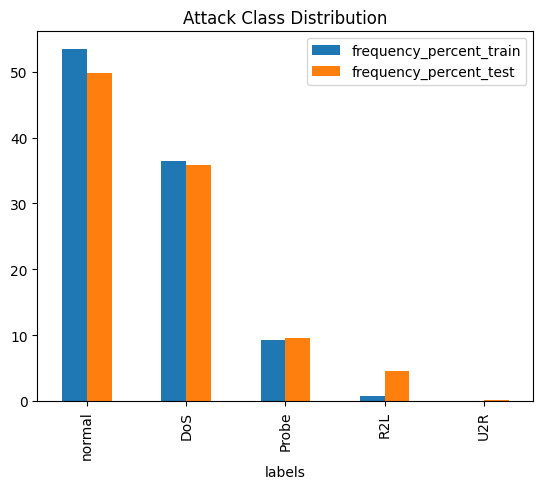

In [ ]:
plot = attack_class_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar")
plot.set_title("Attack Class Distribution")

In [ ]:
train['protocol_type'].unique()

array(['tcp', 'udp', 'icmp'], dtype=object)

<Figure size 800x600 with 0 Axes>

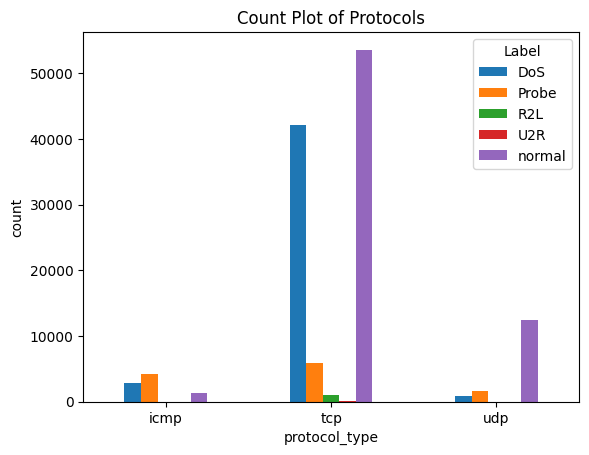

In [ ]:
protocol_counts = train.groupby(['protocol_type', 'labels']).size().unstack()

plt.figure(figsize=(8, 6))
protocol_counts.plot(kind='bar')
plt.title('Count Plot of Protocols')
plt.xlabel('protocol_type')
plt.ylabel('count')
plt.legend(title='Label')
plt.xticks(rotation=0)
plt.show()

In [ ]:
train['flag'].unique()

array(['SF', 'S0', 'REJ', 'RSTR', 'SH', 'RSTO', 'S1', 'RSTOS0', 'S3',
       'S2', 'OTH'], dtype=object)

<Figure size 800x600 with 0 Axes>

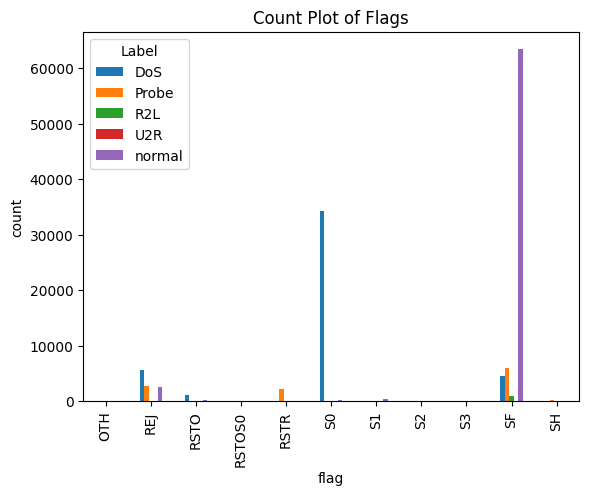

In [ ]:
flag_counts = train.groupby(['flag', 'labels']).size().unstack()

plt.figure(figsize=(8, 6))
flag_counts.plot(kind='bar')
plt.title('Count Plot of Flags')
plt.xlabel('flag')
plt.ylabel('count')
plt.legend(title='Label')
plt.xticks(rotation=90)
plt.show()

In [ ]:
train['service'].unique()

array(['ftp_data', 'other', 'private', 'http', 'remote_job', 'name',
       'netbios_ns', 'eco_i', 'mtp', 'telnet', 'finger', 'domain_u',
       'supdup', 'uucp_path', 'Z39_50', 'smtp', 'csnet_ns', 'uucp',
       'netbios_dgm', 'urp_i', 'auth', 'domain', 'ftp', 'bgp', 'ldap',
       'ecr_i', 'gopher', 'vmnet', 'systat', 'http_443', 'efs', 'whois',
       'imap4', 'iso_tsap', 'echo', 'klogin', 'link', 'sunrpc', 'login',
       'kshell', 'sql_net', 'time', 'hostnames', 'exec', 'ntp_u',
       'discard', 'nntp', 'courier', 'ctf', 'ssh', 'daytime', 'shell',
       'netstat', 'pop_3', 'nnsp', 'IRC', 'pop_2', 'printer', 'tim_i',
       'pm_dump', 'red_i', 'netbios_ssn', 'rje', 'X11', 'urh_i',
       'http_8001', 'aol', 'http_2784', 'tftp_u', 'harvest'], dtype=object)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

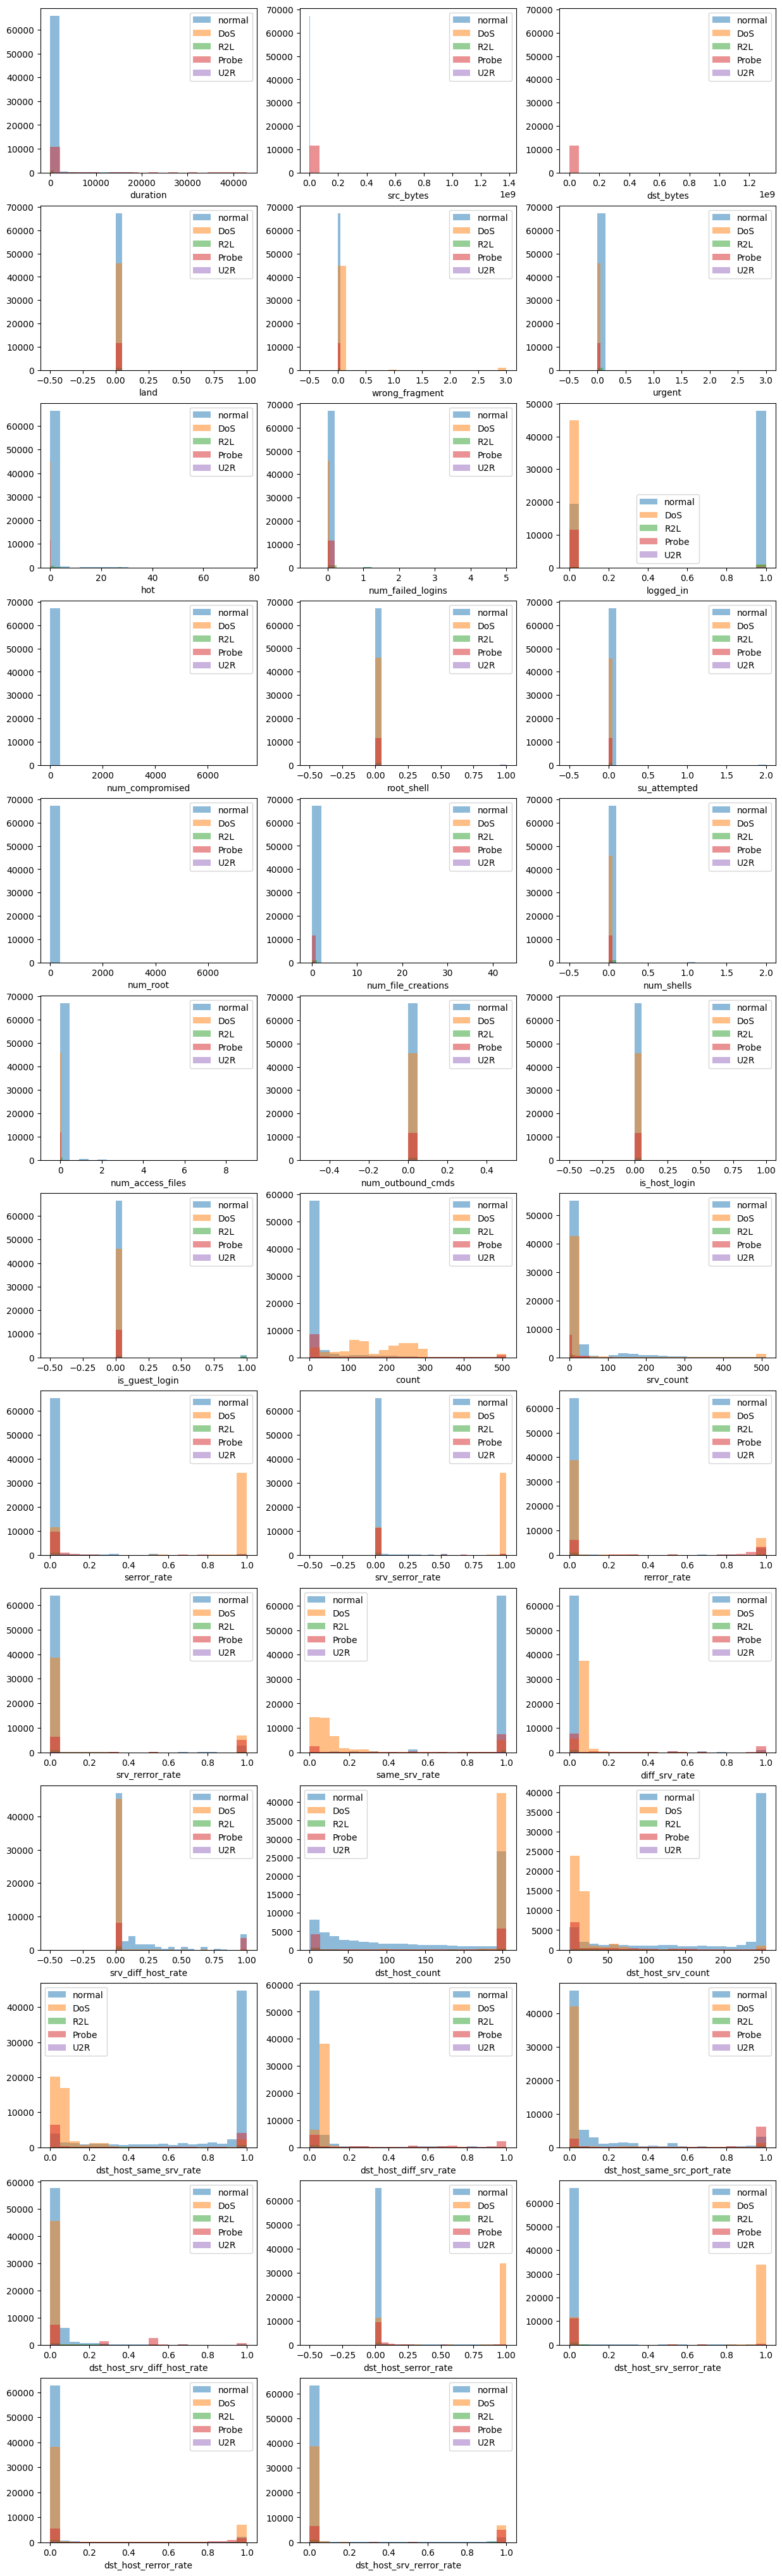

In [ ]:
def visualize_numerical_cols(features, subplots_per_row = 3):

  num_rows = -(-len(features) // subplots_per_row)

  fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(15, 4 * num_rows))
  axes = axes.flatten()

  for i, col in enumerate(features):
      for label in train['labels'].unique():
          label_data = train[train['labels'] == label][col]
          axes[i].hist(label_data, bins=20, alpha=0.5, label=label)

      axes[i].set_xlabel(col)
      axes[i].legend()

  for j in range(i + 1, len(axes)):
      axes[j].axis('off')

  return plt

visualize_numerical_cols(numerical_features)

In [ ]:
train_binary = train.copy()
test_binary = test.copy()

types = train["labels"].unique()[1:]

train_binary['labels'] = train["labels"].replace(to_replace=types,value="attacking", inplace = False)
test_binary['labels'] = test["labels"].replace(to_replace=types,value="attacking", inplace = False)

In [ ]:
le = LabelEncoder()

train[categorical_features] = train[categorical_features].apply(lambda col: le.fit_transform(col))
test[categorical_features] = test[categorical_features].apply(lambda col: le.fit_transform(col))

train_binary[categorical_features] = train_binary[categorical_features].apply(lambda col: le.fit_transform(col))
test_binary[categorical_features] = test_binary[categorical_features].apply(lambda col: le.fit_transform(col))

train.head()
test_binary.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,5,1,51,9,2429,475,0,0,0,0,...,57,0.11,0.02,0.01,0.04,0.0,0.0,0.87,0.0,1
1,0,2,12,9,45,134,0,0,0,0,...,155,0.80,0.02,0.01,0.00,0.0,0.0,0.00,0.0,1
2,0,2,12,9,45,80,0,0,0,0,...,255,1.00,0.00,0.01,0.00,0.0,0.0,0.00,0.0,1
3,1979,2,41,9,145,105,0,0,0,0,...,2,0.01,0.84,1.00,0.00,0.0,0.0,0.00,0.0,1
4,14462,1,41,4,1,0,0,0,0,0,...,2,0.01,0.68,1.00,0.00,0.0,0.0,1.00,1.0,0


<Axes: >

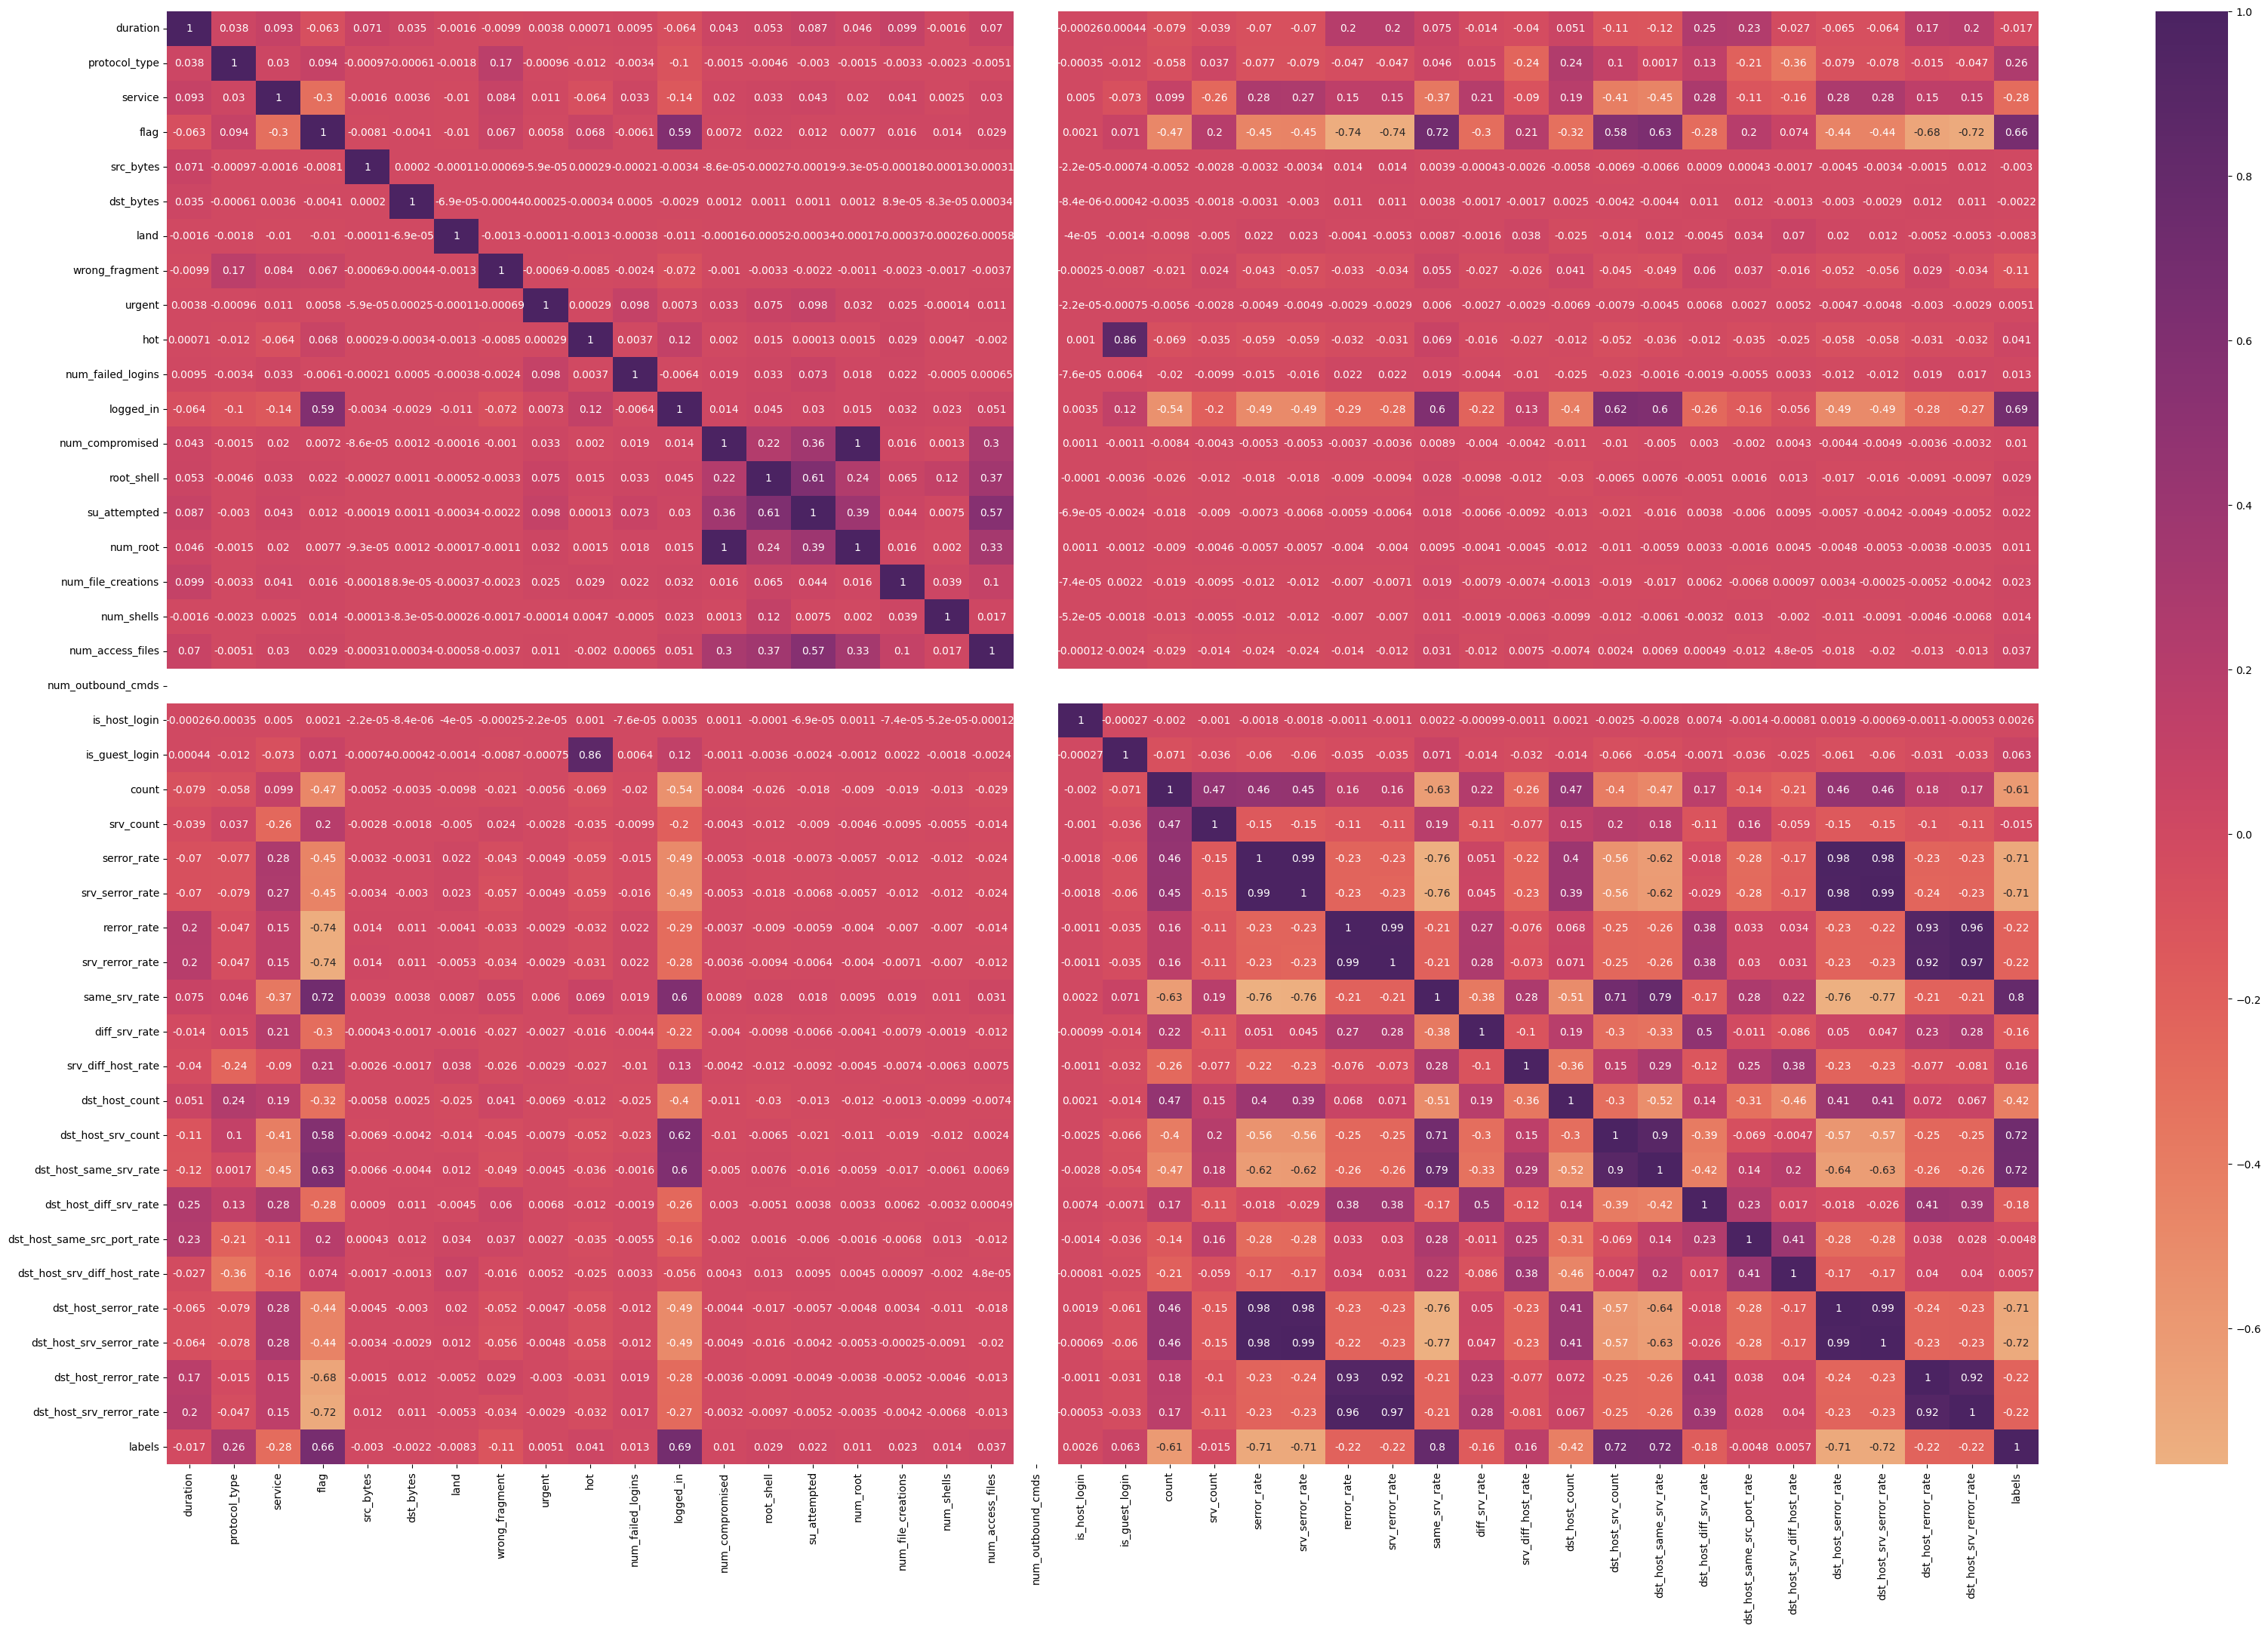

In [ ]:
plt.figure(figsize=(40,25))
sns.heatmap(train.corr(),annot= True,cmap = 'flare')

In [ ]:
corr_matrix = train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9) or any(upper[column] < 0.0001)]


train_feature_selection = train.drop(to_drop, axis=1, inplace=False)
test_feature_selection = test.drop(to_drop, axis=1, inplace=False)

train_binary_feature_selection = train_binary.drop(to_drop, axis=1, inplace=False)
test_binary_feature_selection = train_binary.drop(to_drop, axis=1, inplace=False)

In [ ]:
numerical_features_selected = [x for x in numerical_features if x not in to_drop]

In [ ]:
scaler = StandardScaler()

train[numerical_features] = scaler.fit_transform(train[numerical_features])
test[numerical_features] = scaler.fit_transform(test[numerical_features])

train_binary[numerical_features] = scaler.fit_transform(train_binary[numerical_features])
test_binary[numerical_features] = scaler.fit_transform(test_binary[numerical_features])

train_feature_selection[numerical_features_selected] = scaler.fit_transform(train_feature_selection[numerical_features_selected])
test_feature_selection[numerical_features_selected] = scaler.fit_transform(test_feature_selection[numerical_features_selected])

train_binary_feature_selection[numerical_features_selected] = scaler.fit_transform(train_binary_feature_selection[numerical_features_selected])
test_binary_feature_selection[numerical_features_selected] = scaler.fit_transform(test_binary_feature_selection[numerical_features_selected])

train.head()
test.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,-0.116219,1,51,9,-0.021090,-0.039596,-0.009419,-0.07811,-0.010877,-0.091546,...,-0.592691,-0.974283,-0.324834,-0.429145,0.110651,-0.558559,-0.547234,2.107579,-0.438112,4
1,-0.118508,2,12,9,-0.026199,-0.045014,-0.009419,-0.07811,-0.010877,-0.091546,...,0.285640,0.569104,-0.324834,-0.429145,-0.266835,-0.558559,-0.547234,-0.456918,-0.438112,4
2,-0.118508,2,12,9,-0.026199,-0.045873,-0.009419,-0.07811,-0.010877,-0.091546,...,1.181897,1.016463,-0.424929,-0.429145,-0.266835,-0.558559,-0.547234,-0.456918,-0.438112,4
3,0.787500,2,41,9,-0.025985,-0.045475,-0.009419,-0.07811,-0.010877,-0.091546,...,-1.085632,-1.197962,3.779090,2.811112,-0.266835,-0.558559,-0.547234,-0.456918,-0.438112,4
4,6.502357,1,41,4,-0.026294,-0.047144,-0.009419,-0.07811,-0.010877,-0.091546,...,-1.085632,-1.197962,2.978325,2.811112,-0.266835,-0.558559,-0.547234,2.490779,2.414926,1


In [ ]:
train.to_csv('/content/drive/MyDrive/ML-Data/scaled_train.csv', index=False)
test.to_csv('/content/drive/MyDrive/ML-Data/scaled_test.csv', index=False)

In [ ]:
train_binary.to_csv('/content/drive/MyDrive/ML-Data/scaled_train_binary.csv', index=False)
test_binary.to_csv('/content/drive/MyDrive/ML-Data/scaled_test_binary.csv', index=False)

In [ ]:
train_binary_feature_selection.to_csv('/content/drive/MyDrive/ML-Data/scaled_train_binary_feature_selection.csv', index=False)
test_binary_feature_selection.to_csv('/content/drive/MyDrive/ML-Data/scaled_test_binary_feature_selection.csv', index=False)

In [ ]:
train_feature_selection.to_csv('/content/drive/MyDrive/ML-Data/scaled_train_feature_selection.csv', index=False)
test_feature_selection.to_csv('/content/drive/MyDrive/ML-Data/scaled_test_feature_selection.csv', index=False)